In [1]:
import glob, math, os, random, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [2]:
! ls /home/jovyan/nas-dataset/JUPR/MAM20044/Bad/*.png | wc -l
! ls /home/jovyan/nas-dataset/JUPR/MAM20044/Good/*.png | wc -l
! ls /home/jovyan/nas-dataset/JUPR/888/*.jpg | wc -l

7
17763
104


In [2]:
sigmoid = lambda z: 1/(1+math.e**(-z)) if z>-750 else 0

class ResultUnlabeled: # inference on good folder -> pick bad and random pick 
    def __init__(self, pdNpyPath, c0ImgPathL, threshold):
        scoreL   = [ sigmoid(gmmScore) for gmmScore in np.load(pdNpyPath) ]
        #assert len(scoreL)==len(c0ImgPathL), (len(scoreL),len(c0ImgPathL))
        resultL  = sorted(list(zip(scoreL, c0ImgPathL)))
        self.pdB = [ (score,os.path.abspath(imgPath)) for score,imgPath in resultL if score<threshold  ]
        self.pdG = [ (score,os.path.abspath(imgPath)) for score,imgPath in resultL if score>=threshold ]
        self.outputPath = os.path.abspath(pdNpyPath+"/../")
        print(f"predict negative rate = {len(self.pdB)/len(resultL)}")
        
    def plotDistribution(self):
        plt.plot( [ score for score,_ in self.pdB ] )
        plt.xlabel(f"data sorted by score", fontsize=16)
        plt.ylabel("confidence", fontsize=16)
        plt.grid(1)
        plt.show()
    
    def visualize(self, bTopN=30, gMaxN=30):
        self.samplePdB = self.pdB[:bTopN]
        self.samplePdG = random.Random(7).sample(self.pdG, gMaxN)
        if 1: return
        for mode,sampleL in zip(['pd-Bad','pd-Good'], [self.samplePdB, self.samplePdG]):
            print(mode)        
            rows = len(sampleL)//10
            plt.figure( figsize=(6*10,6*rows) )
            for i in range(rows):
                for j in range(10):
                    plt.subplot(rows,10,10*i+j+1)
                    plt.imshow( cv2.imread( sampleL[10*i+j][1] )[:,:,::-1] )
                    plt.axis('off')
                    plt.title( str(10*i+j), fontsize=32 )
            plt.show()
        
    def save(self, TP, FP, FN, TN):
        pathM = [ [ [ self.samplePdB[i][1] for i in TP ], [ self.samplePdB[i][1] for i in FP ] ], \
                  [ [ self.samplePdG[i][1] for i in FN ], [ self.samplePdG[i][1] for i in TN ] ] ]
        M = np.array([ [len(pathM[0][0]), len(pathM[0][1])], [len(pathM[1][0]), len(pathM[1][1])] ])
        #
        axis0sum = M.sum(axis=0)
        N = M.copy().astype(np.float)
        for i in range(len(N)):
            if axis0sum[i] != 0:
                N[:,i] /= axis0sum[i]
        #
        axis1sum = M.sum(axis=1)
        P = M.copy().astype(np.float)
        for i in range(len(P)):
            if axis1sum[i] != 0:
                P[i,:] /= axis1sum[i]
        #
        plt.figure(figsize=(5*3,4))
        # fig1 - number
        fig = plt.subplot(1,3,1)
        plt.title(f"Confusion Matrix - Number (conf={0.5})", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig2 - precision
        fig = plt.subplot(1,3,2)
        plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, round(P[i][j],3), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig3 - recall
        fig = plt.subplot(1,3,3)
        plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, round(N[i][j],3), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
        #plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
        plt.savefig(f"{self.outputPath}/confusion.jpg")
        plt.show()
        json.dump( pathM, open(f"{self.outputPath}/confusion.json", "w") ) # 00:PD_B_GT_B, 01:PD_B_GT_G, 10:PD_G_GT_B, 11:PD_G_GT_G

predict negative rate = 0.01424308956820357


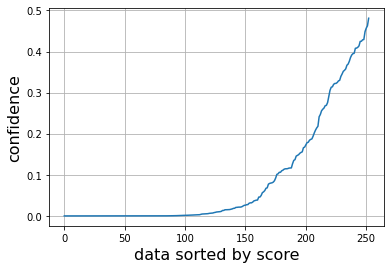

In [3]:
obj = ResultUnlabeled(pdNpyPath="../experiments/multimodal/_old/cats_vs_dogs_mam_v1_inf_all/class_0/model/o_test_finetuned_samples_likelihood.npy",
                      c0ImgPathL=sorted(glob.glob(f"../_data/_old/mam_v0_unlabeled/test/c0/*.png")),
                      threshold=0.5
)
obj.plotDistribution()
obj.visualize()

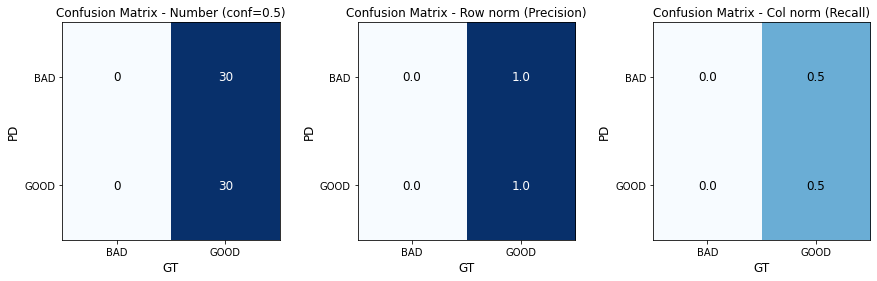

In [4]:
TP = []
FP = list(range(30))
FN = []
TN = list(range(30))
obj.save(TP, FP, FN, TN)